# BioConvert 
## Materials for manuscripts

In [1]:
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (9,7)
rcParams["figure.dpi"] = 200
from IPython .display import Image



In [2]:
from bioconvert.core.registry import Registry
import os

In [3]:
os.makedirs("manuscripts", exist_ok=True)

# Histogram number of methods per conversion

Number of formats: 49
Number of converters: 100
Number of methods : 154


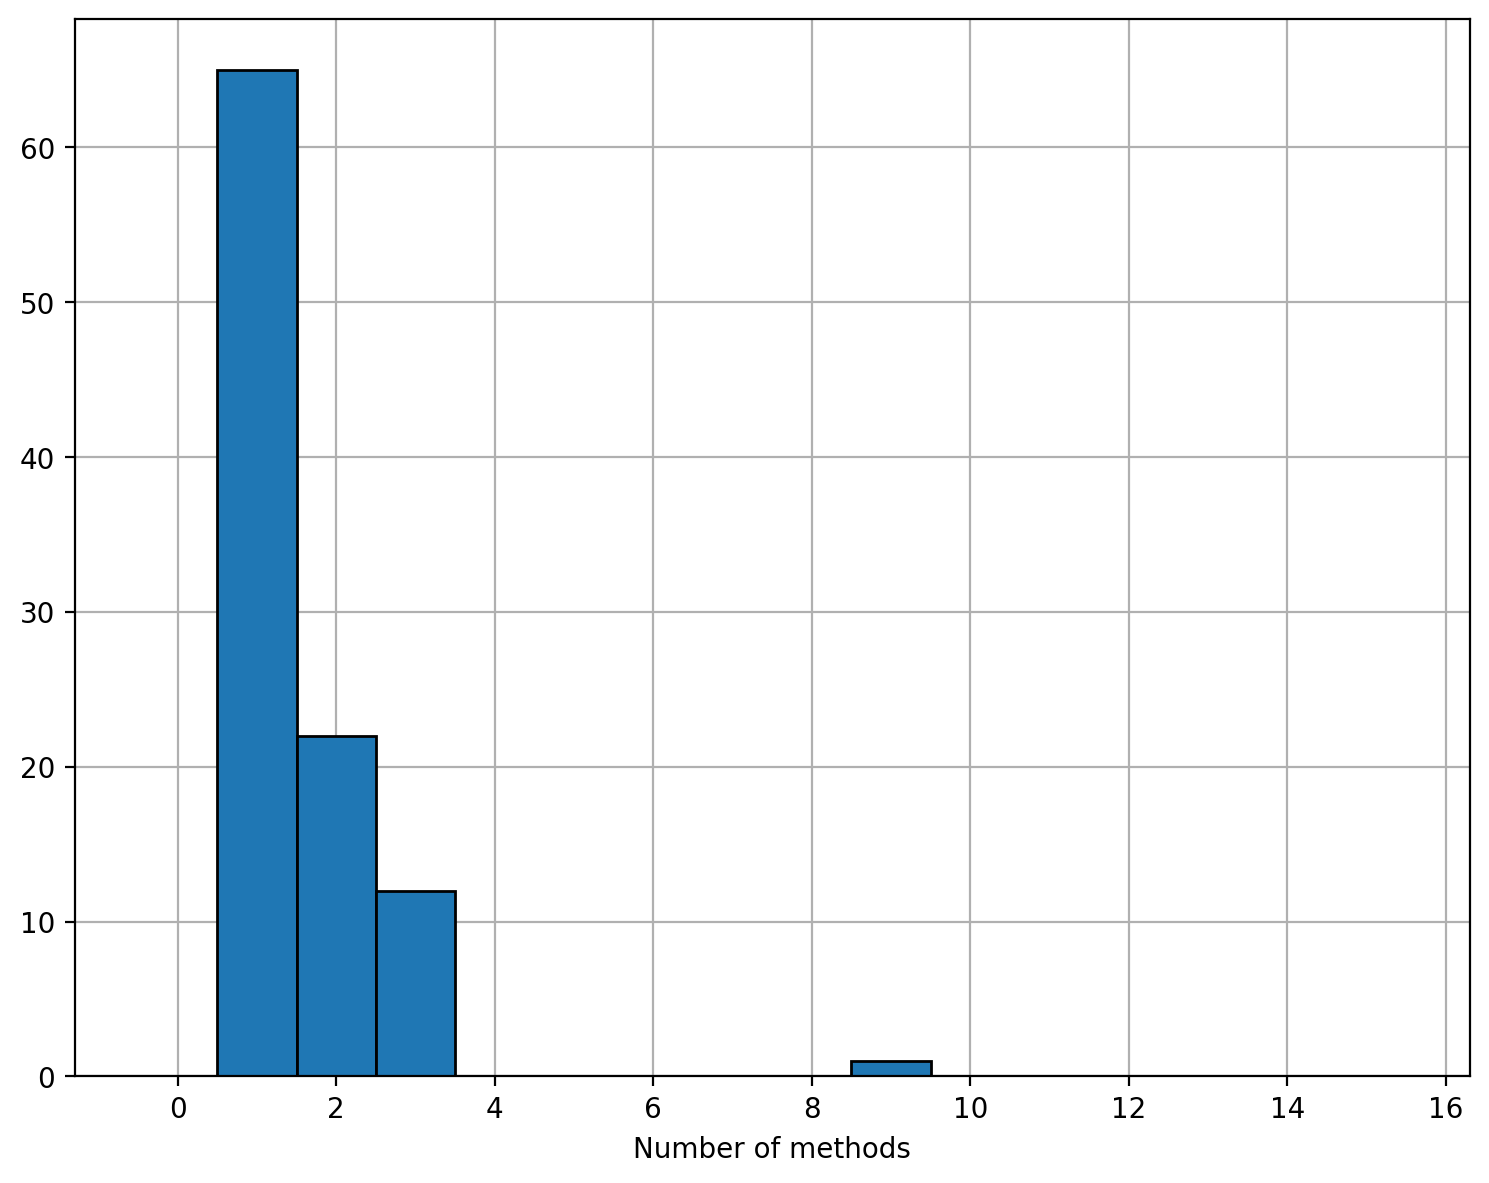

In [4]:
r = Registry()
info = r.get_info()

# The available unique converters
converters = [x for x in info.items()]

# the number of methods per converter
data = [info[k] for k, v in info.items()]

# the number of formats
A1 = [y for x in list(r.get_conversions()) for y in x[0]]
A2 = [y for x in list(r.get_conversions()) for y in x[1]]
formats = set(A1 + A2)

print("Number of formats: {}".format(len(formats)))
print("Number of converters: {}".format(len(converters)))
print("Number of methods : {}".format(sum(data)))

hist(data, range(17), ec="k", zorder=2, align="left")
xlabel("Number of methods")
grid(zorder=-1)

for ext in ['png', 'svg', 'eps', 'pdf']:
    savefig(f"manuscripts/hist_data.{ext}")

# Graph clustered

In [5]:
from bioconvert.core.graph import create_graph


In [6]:
_ = create_graph("manuscripts/graph_clustered_conversion.png", use_singularity=False, include_subgraph=True)

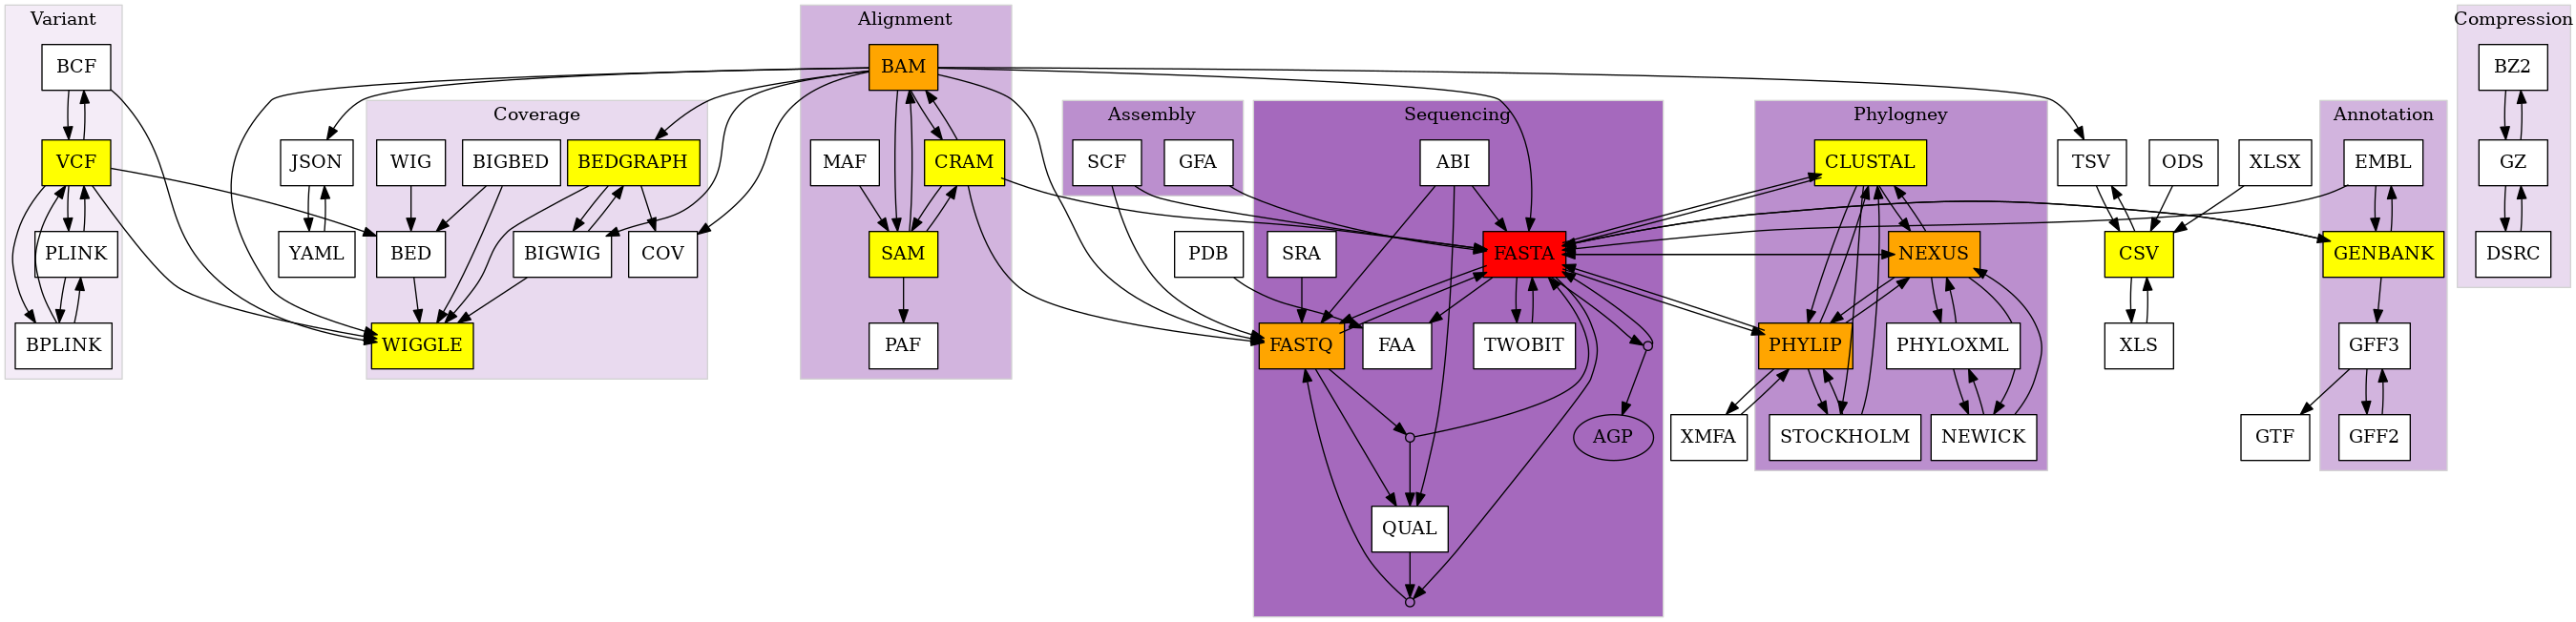

In [7]:
Image(filename="manuscripts/graph_clustered_conversion.png")

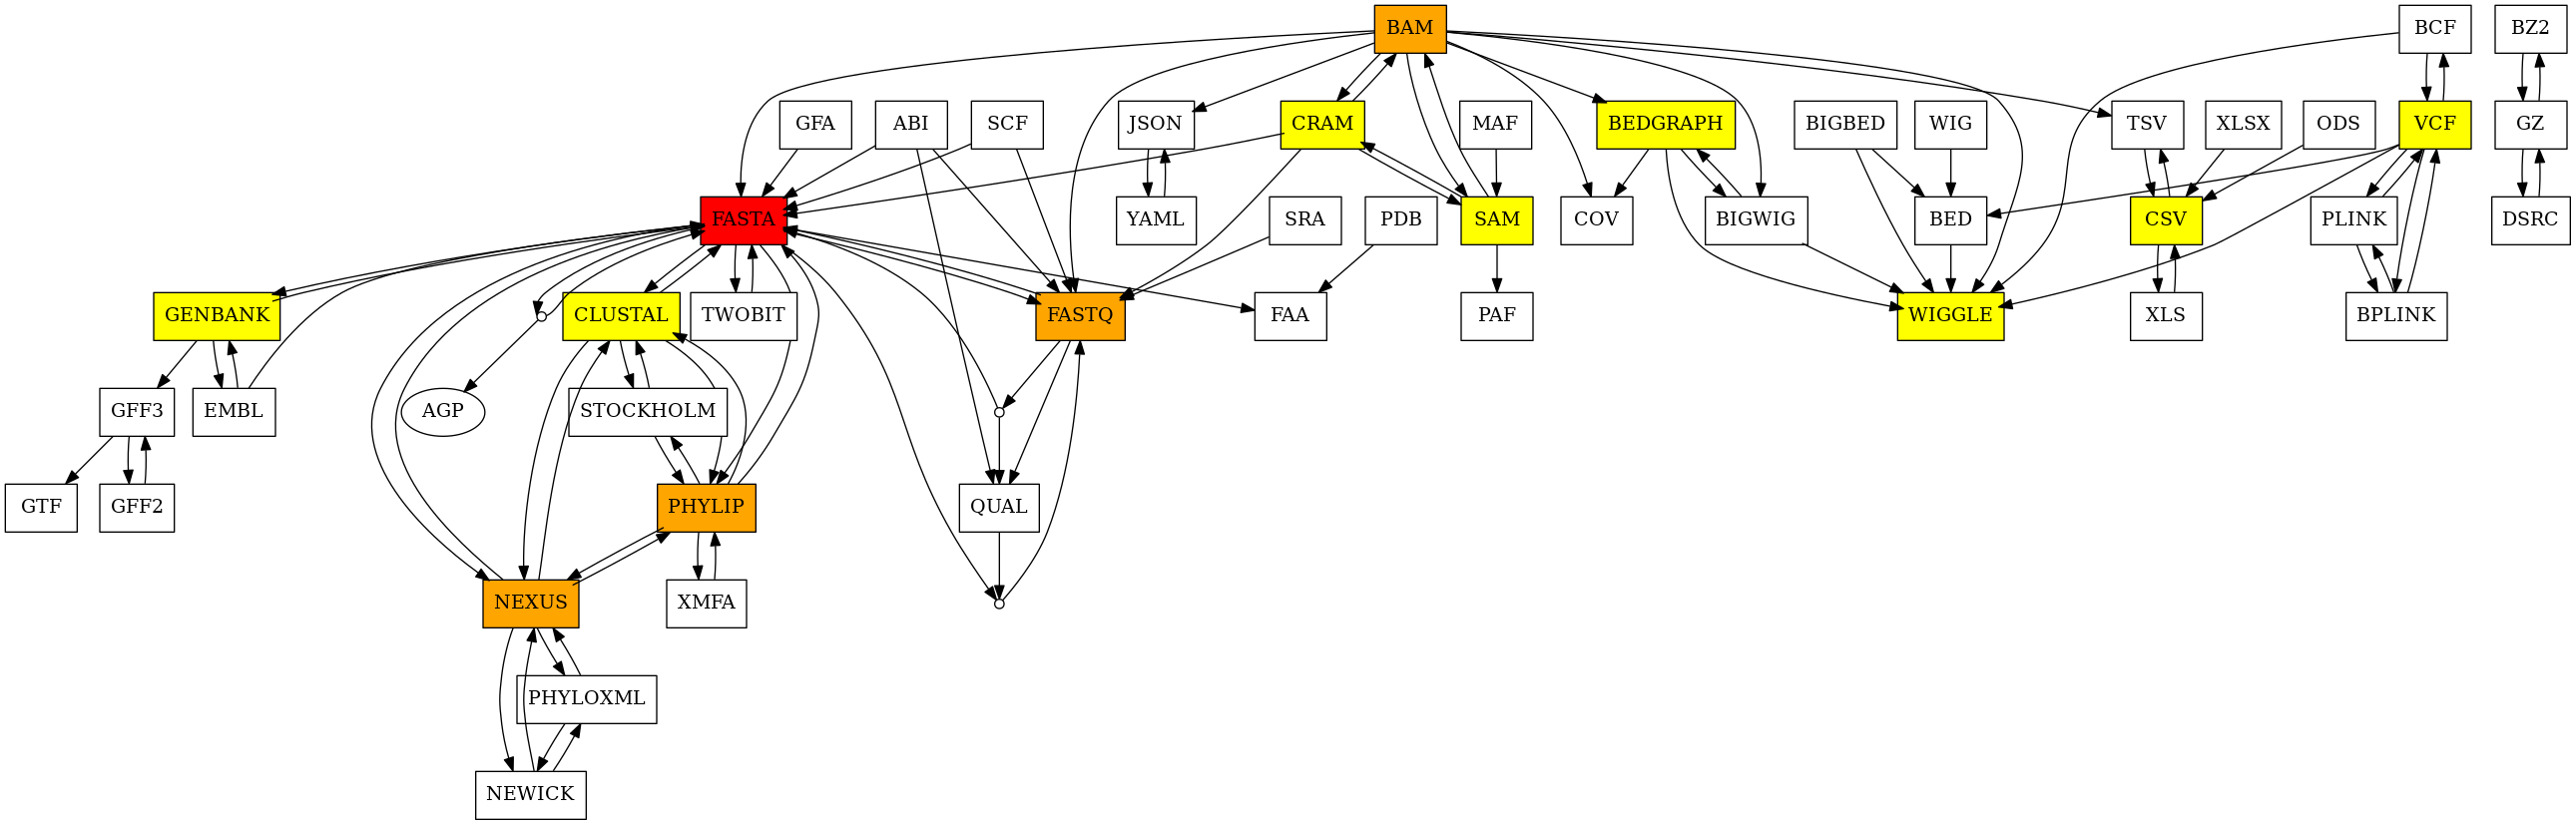

In [8]:
_ = create_graph("manuscripts/graph_conversion.png", use_singularity=False)
Image(filename="manuscripts/graph_conversion.png")

# Benchmarking
##  Bam2cov

Evaluating method samtools: 100%|███████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]


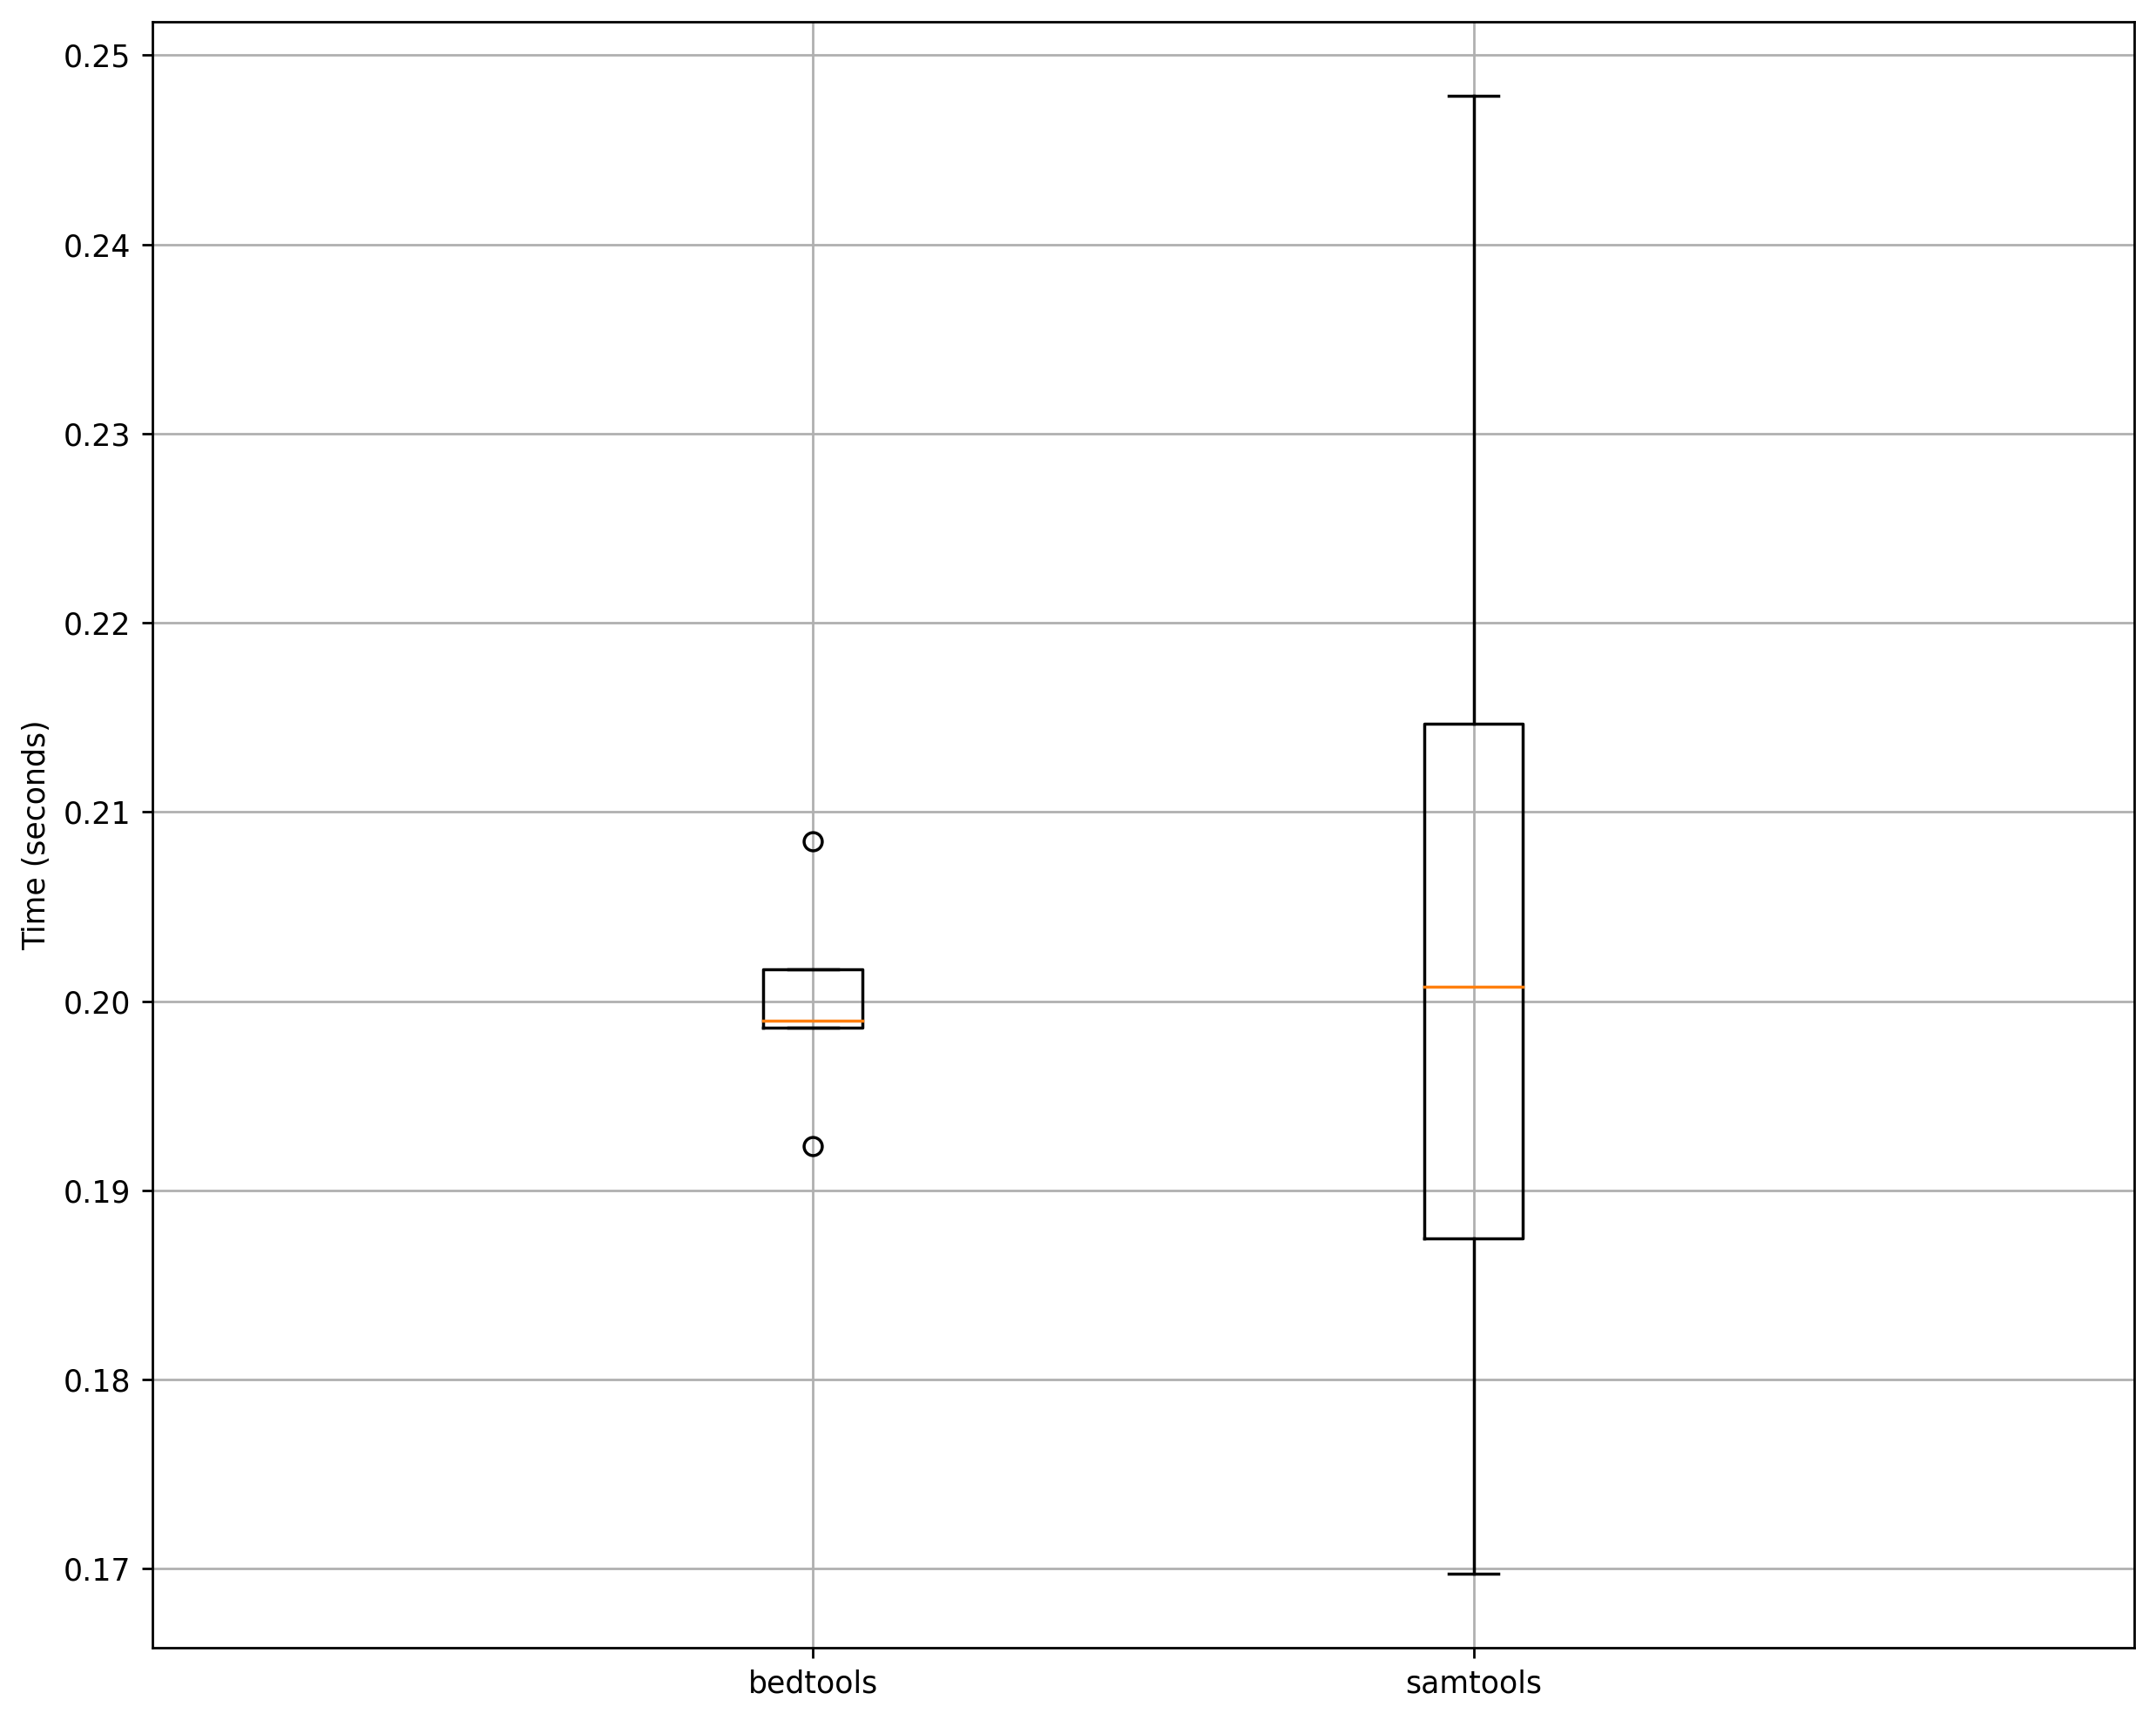

In [39]:
from bioconvert import Benchmark
from bioconvert import bioconvert_data
from bioconvert.bam2cov import BAM2COV
from bioconvert.fastq2fasta import FASTQ2FASTA

input_file = bioconvert_data("test_measles.sorted.bam")
conv = BAM2COV(input_file, "test.cov")
_ = bench = Benchmark(conv)
_ = bench.plot()

# Benchmarking FastQ2Fasta (simulated data)
## Input/Output data is not compressed

Evaluating method seqtk: 100%|████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


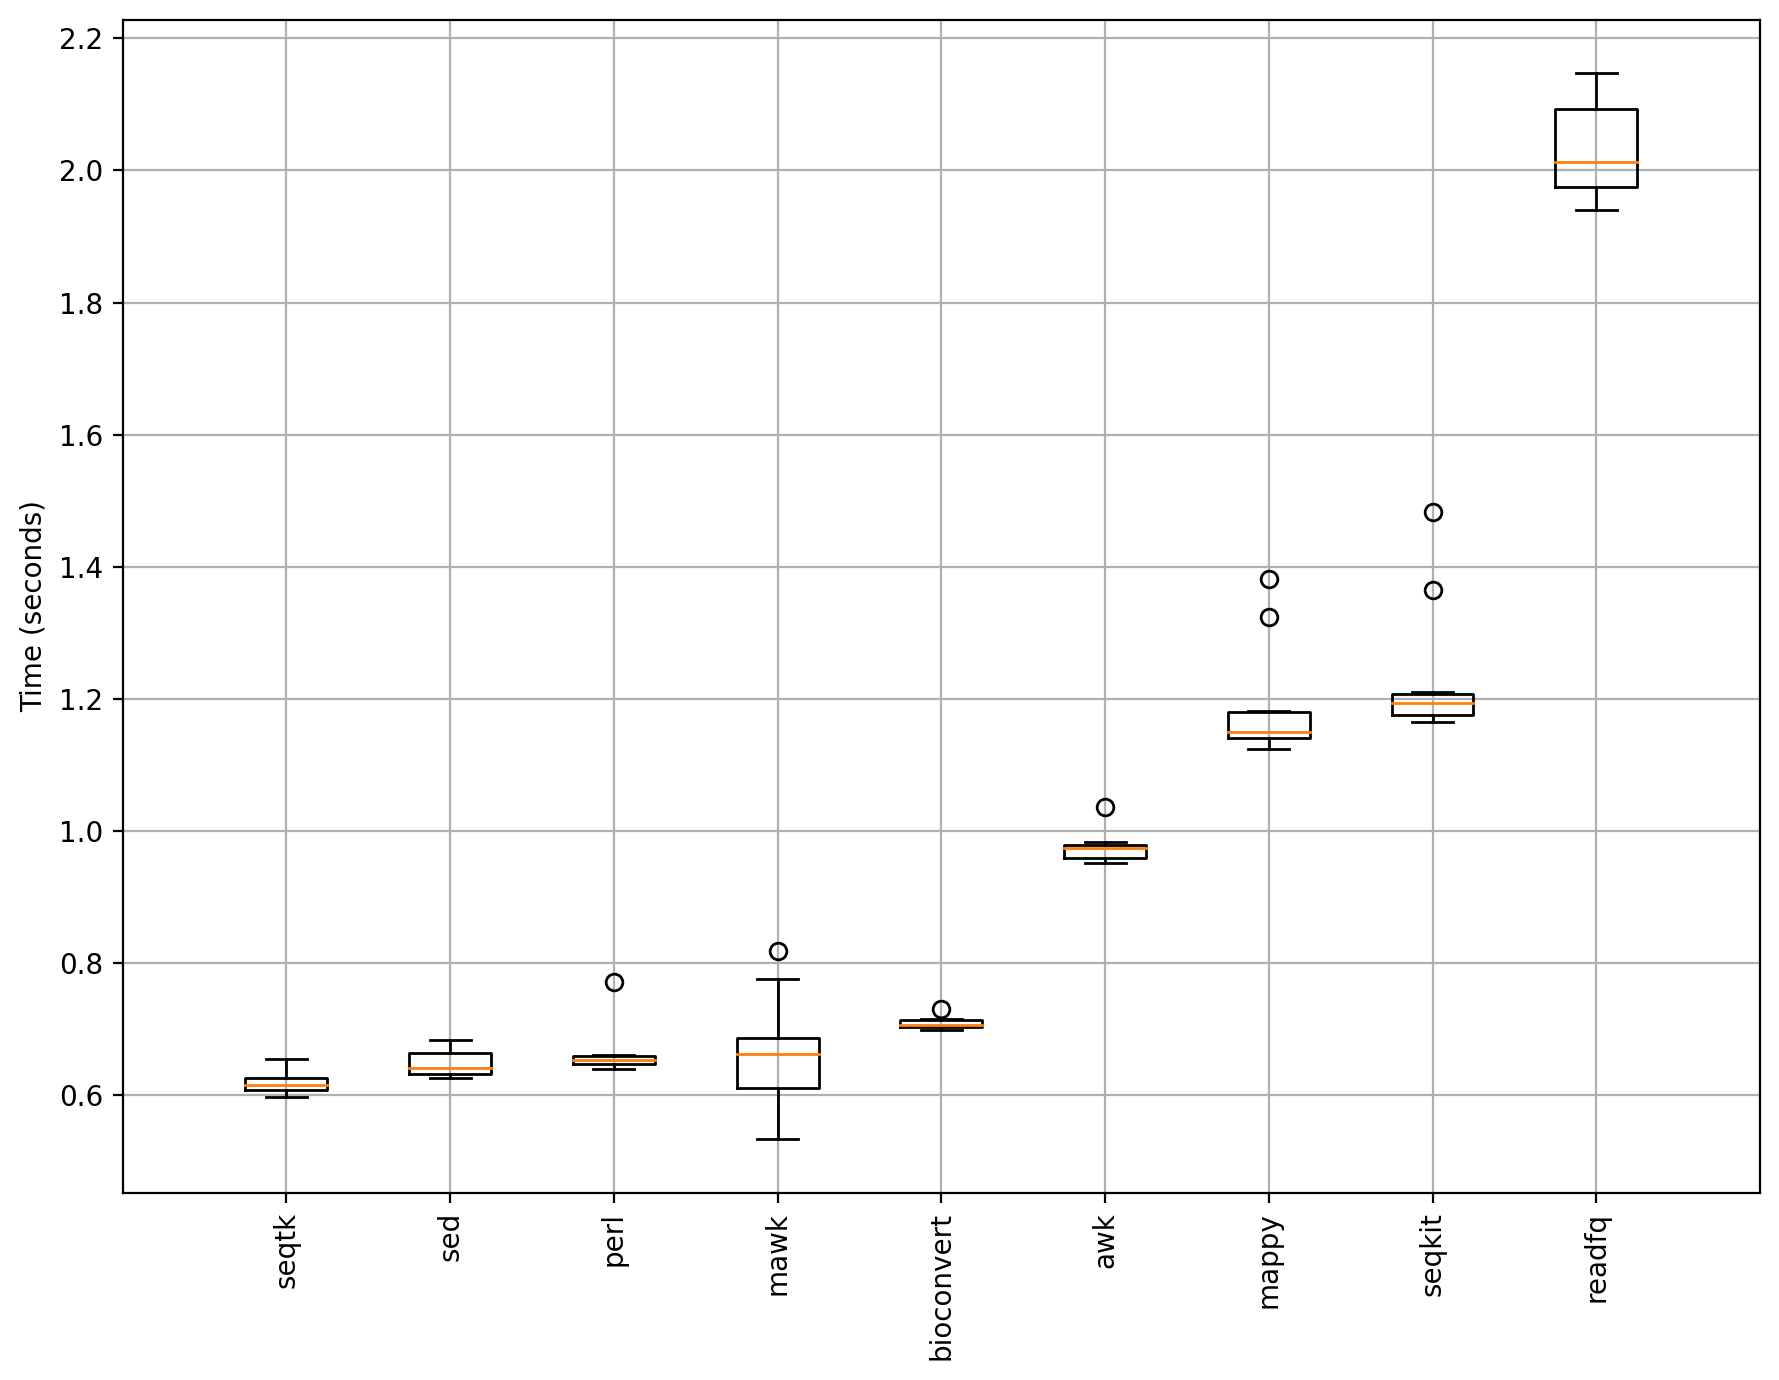

In [54]:
# Generate the dummy data, saving the results in a temporary file
from easydev import TempFile
from bioconvert.simulator.fastq import FastqSim

infile = TempFile(suffix=".fastq")
outfile = TempFile(suffix=".fasta")
fs = FastqSim(infile.name)
fs.nreads = 1000000 # 1,000,000 by default
fs.simulate()

# Perform the benchmarking
c = FASTQ2FASTA(infile.name, outfile.name)
c.boxplot_benchmark(N=10)

infile.delete()
outfile.delete()
savefig("manuscripts/benchmark_fastq2fasta_uncompressed_1000000.png")

## Same benchmark as above with compresssed input fastq file

Evaluating method seqtk: 100%|████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


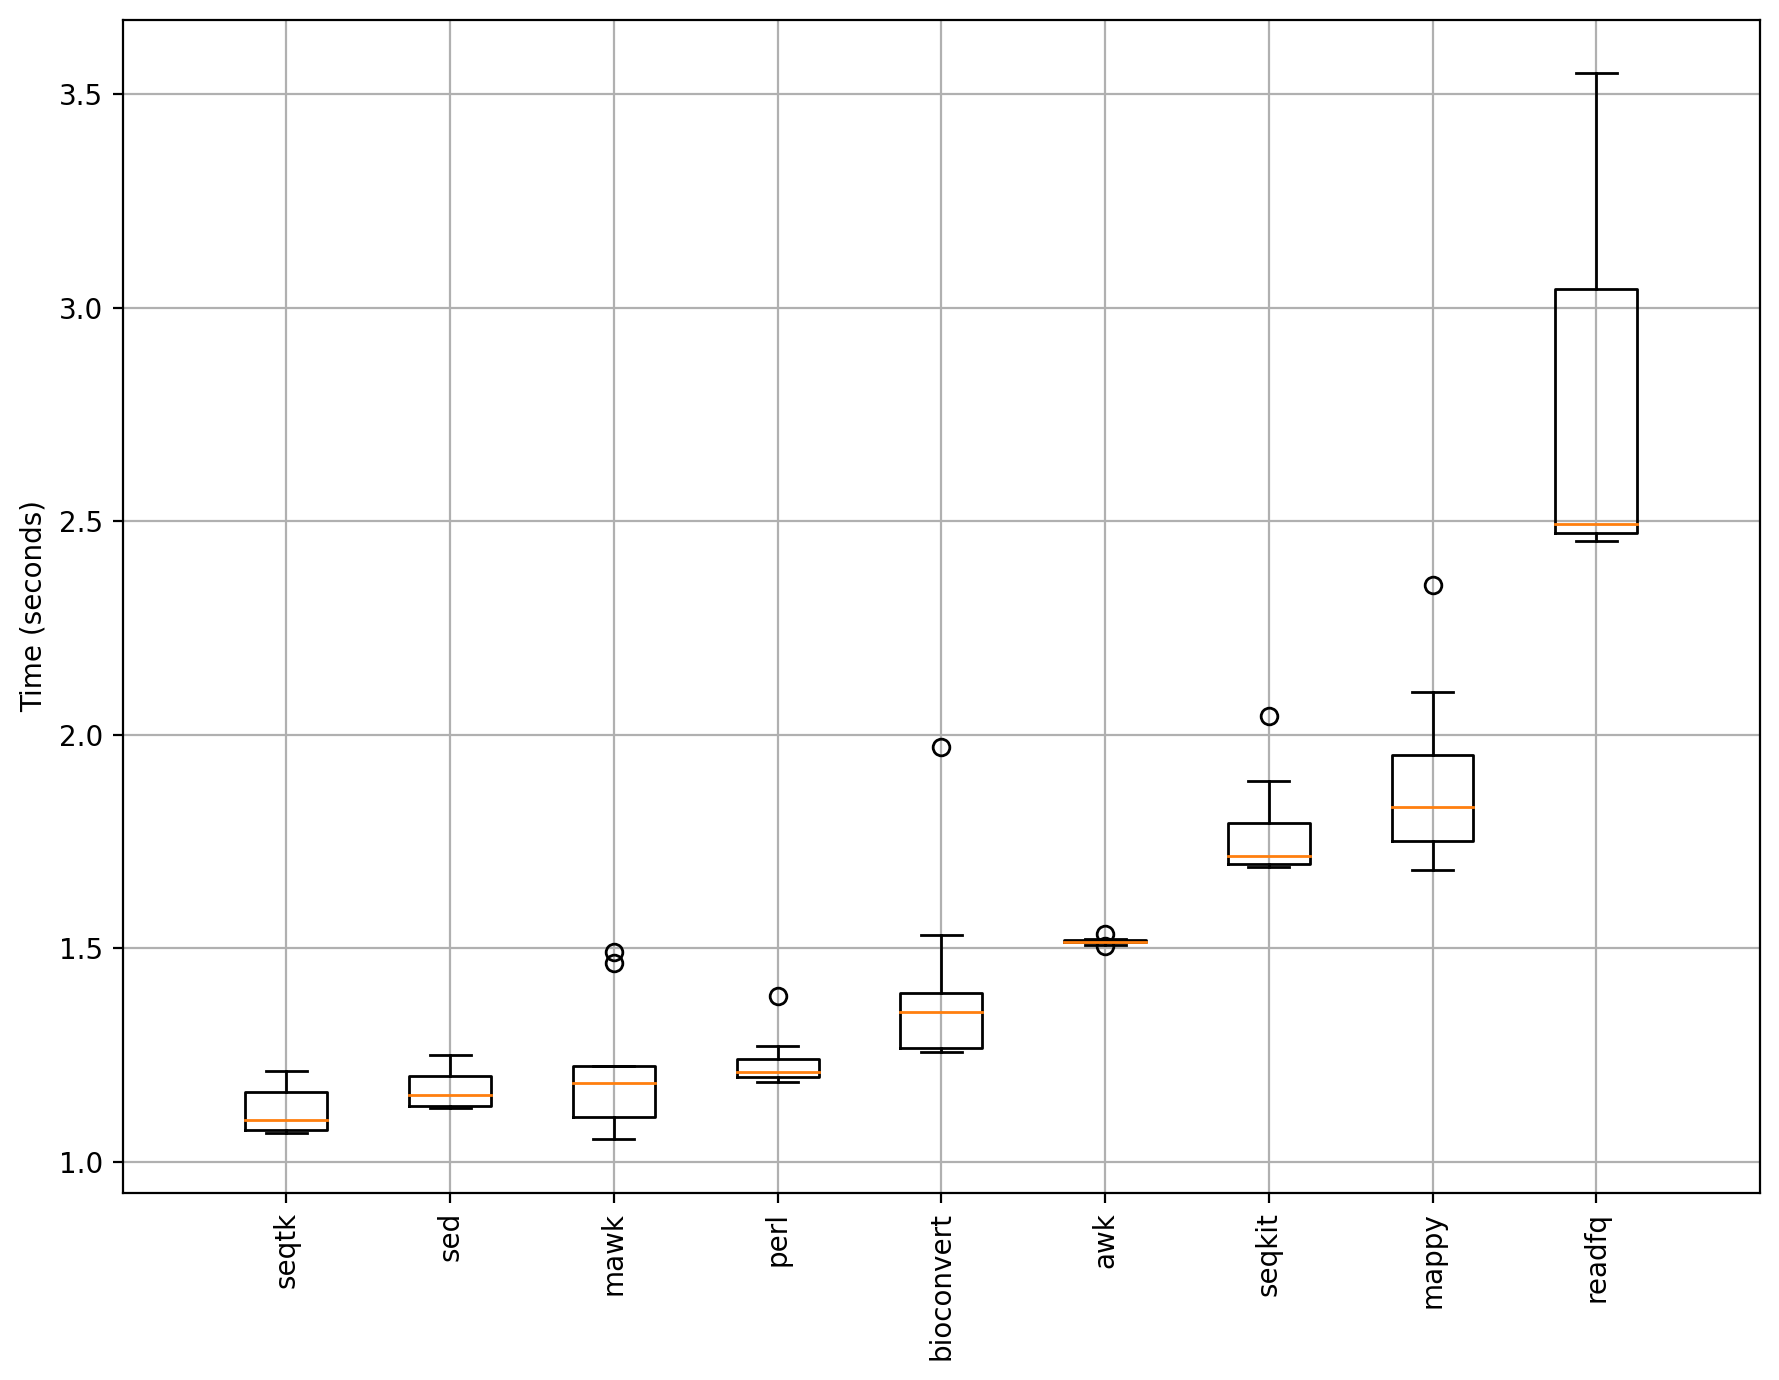

In [53]:

infile = TempFile(suffix=".fastq")
outfile = TempFile(suffix=".fasta")
fs = FastqSim(infile.name)
fs.nreads = 1000000 # 1,000,000 by default
fs.simulate()

cmd = f"pigz {infile.name}"
import subprocess
subprocess.run(cmd.split())
# Perform the benchmarking
c = FASTQ2FASTA(infile.name + ".gz", outfile.name)
c.boxplot_benchmark(N=10)

cmd = f"unpigz {infile.name}"
subprocess.run(cmd.split())

infile.delete()
outfile.delete()

# Multi benchmark

First, we can download some test data that are posted on Zenodo

In [55]:
! wget https://zenodo.org/record/6405971/files/measles.sorted.bam -O inputs/test.bam
! wget https://zenodo.org/record/6405971/files/measles.sorted.bam.bai -O inputs/test.bam.bai


--2022-10-17 11:26:14--  https://zenodo.org/record/6405971/files/measles.sorted.bam
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68393900 (65M) [application/octet-stream]
Saving to: ‘inputs/test.bam’

inputs/test.bam     100%[===================>]  65.22M  6.45MB/s    in 14s     

2022-10-17 11:26:29 (4.62 MB/s) - ‘inputs/test.bam’ saved [68393900/68393900]

--2022-10-17 11:26:29--  https://zenodo.org/record/6405971/files/measles.sorted.bam.bai
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96 [application/octet-stream]
Saving to: ‘inputs/test.bam.bai’

inputs/test.bam.bai 100%[===================>]      96  --.-KB/s    in 0s      

2022-10-17 11:26:30 (7.98 MB/s) - ‘inputs/test.bam.bai’ saved [96/96]



Then, we run the same benachmark as before using the bioconvert command;
However, we will launch it several times (benchmark_num=5) and gather results as josn files into ./json

In [69]:
from tqdm import tqdm

benchmark_num = 5
for i in tqdm(range(benchmark_num), position=1):
    cmd = f"bioconvert bam2sam -b -N 10 -T json/test_bam2sam_{i} inputs/test.bam outputs/test.sam -f"
    subprocess.run(cmd.split())


Evaluating method sambamba:   0%|          | 0/10 [00:00<?, ?it/s]
sambamba 0.8.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2020
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)

Evaluating method sambamba:  10%|█         | 1/10 [00:01<00:14,  1.59s/it]
sambamba 0.8.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2020
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)

Evaluating method sambamba:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]
sambamba 0.8.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2020
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)

Evaluating method sambamba:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]
sambamba 0.8.0
 by Artem Tarasov and Pjotr Prins (C) 2012-2020
    LDC 1.20.0 / DMD v2.090.1 / LLVM7.0.0 / bootstrap LDC - the LLVM D compiler (0.17.6)

Evaluating method sambamba:  40%|████      | 4/10 [00:05<00:08,  1.46s/it]
sambamba 0.8.0
 by A

Here we gather the different json files into a single data structure

In [76]:
import pandas as pd

df = pd.read_json("json/test_bam2sam_0.json")

# Creation of another column containing the benchmarking number
df = df.assign(Benchmark=1)
 
for i in range(1, int(benchmark_num)):
    # open and read JSON file
    df_temp = pd.read_json(f"json/test_bam2sam_{i}.json")

    # Creation of another column containing the benchmarking number
    df_temp = df_temp.assign(Benchmark=i + 1)
 
    # Concatenation of the two JSON objects
    df = pd.concat([df, df_temp], axis=0)
    # The index is reset to avoid problems when exporting the final JSON file
df.reset_index(inplace=True, drop=True)
# Creation of the path variable which will be used to give the name of the output JSON file
# Exporting the JSON object to a JSON file
df.to_json("json/test_bam2sam.json", indent=4)


Finally, we look at the results

- By comparing the sambamba method with the best one (pysam), we check H0: True with corrected P-value: 2.4218491029725757e-07
- By comparing the samtools method with the best one (pysam), we check H0: True with corrected P-value: 1.0241050969984848e-43


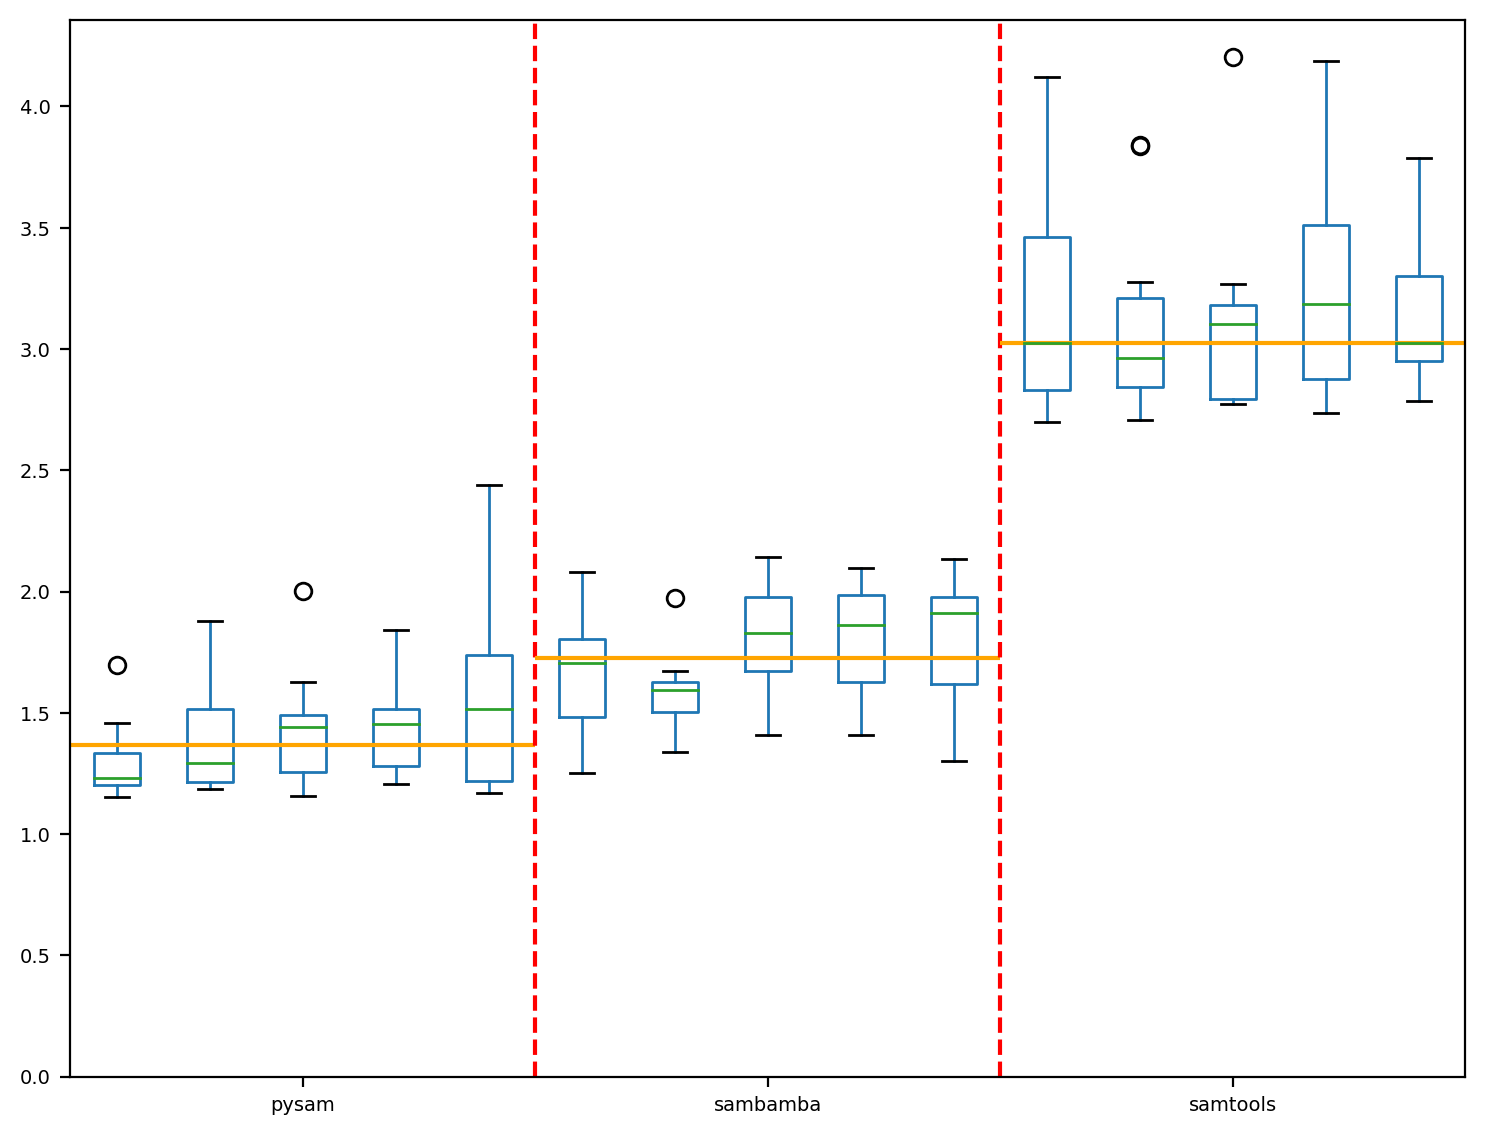

In [77]:
from bioconvert.core.benchmark import plot_multi_benchmark_max
_ = plot_multi_benchmark_max("json/test_bam2sam.json", "manuscripts/benchmark_bam2sam.png") 

# Using samtools 1.15 from damona singularity

- By comparing the pysam method with the best one (samtools), we check H0: True with corrected P-value: 6.242048328741146e-22
- By comparing the sambamba method with the best one (samtools), we check H0: True with corrected P-value: 1.1394544053461425e-36


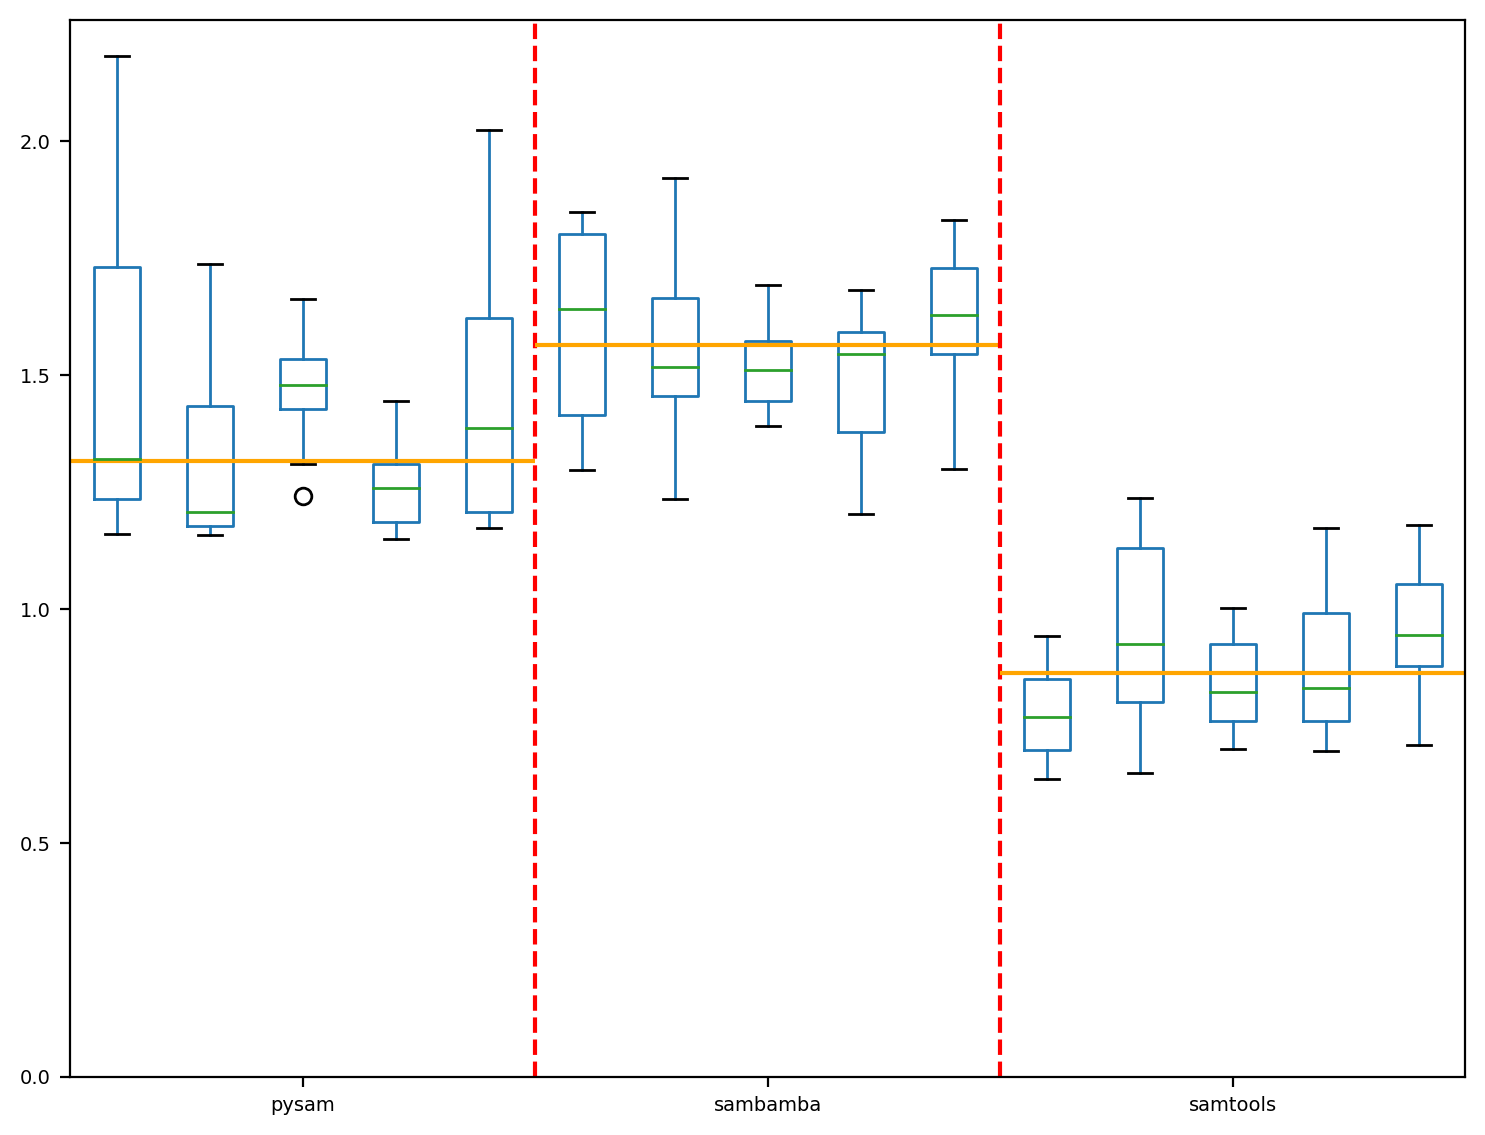

In [78]:

  
df = pd.read_json("json2/test_bam2sam_0.json")

# Creation of another column containing the benchmarking number
df = df.assign(Benchmark=1)

for i in range(1, int(benchmark_num)):
    # open and read JSON file
    df_temp = pd.read_json(f"json2/test_bam2sam_{i}.json")
   
    # Creation of another column containing the benchmarking number
    df_temp = df_temp.assign(Benchmark=i + 1)
   
    # Concatenation of the two JSON objects
    df = pd.concat([df, df_temp], axis=0)
    # The index is reset to avoid problems when exporting the final JSON file
df.reset_index(inplace=True, drop=True)
# Creation of the path variable which will be used to give the name of the output JSON file
# Exporting the JSON object to a JSON file
df.to_json("json2/test_bam2sam.json", indent=4)
_ = plot_multi_benchmark_max("json2/test_bam2sam.json", 
                             "manuscripts/benchmark2_bam2sam.png")